In [1]:
from IPython.core.display import display, HTML
display(HTML("<style>.container { width:95% !important; }</style>"))

In [2]:
from datetime import date, datetime
import numpy as np
import pandas as pd
pd.options.display.float_format = '{:,.3f}'.format
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
import seaborn as sns
sns.set_theme()
sns.set_color_codes()
pd.set_option('display.max_rows', 1000)
pd.set_option('display.max_columns', 50)

# column_names = ['# Seen', 'ALSA', '# Picked', 'ATA', '# GP', 'GP WR', '# OH', 'OH WR', '# GD', 'GD WR', '# GIH', 'GIH WR', '# GND', 'GND WR', 'IWD', 'Color', 'Rarity']

from Utilities import Logger
import WUBRG
from data_graphing.LineColors import LineColors
from game_metadata import SETS, FORMATS
from game_metadata import Card,CardManager, SetMetadata, FormatMetadata
from data_fetching import JSONHandler, RawDataFetcher, RawDataHandler, FramedData, SetManager

LOG_LEVEL = Logger.FLG.DEFAULT
LOG_LEVEL

<Flags.DEFAULT: 3>

# Initialization

In [3]:
set_data = SetManager('NEO')
len(set_data.SET_METADATA.CARD_LIST)

Fetching card data for set: NEO
Fetching data for set: NEO


282

In [4]:
from data_fetching.utils.date_helper import get_next_17lands_update_time, get_prev_17lands_update_time
print(f"Last 17Lands Update: {get_prev_17lands_update_time()}")
print(f"Current UTC Time:    {datetime.utcnow()}")
print(f"Next 17Lands Update: {get_next_17lands_update_time()}")

Last 17Lands Update: 2022-04-24 02:00:00
Current UTC Time:    2022-04-24 22:56:27.793991
Next 17Lands Update: 2022-04-25 02:00:00


In [5]:
set_data.check_for_updates()

Checking for missing data for NEO PremierDraft...
Getting overall data for NEO PremierDraft
Getting data for NEO PremierDraft, date: 2022-02-10
Getting data for NEO PremierDraft, date: 2022-02-11
Getting data for NEO PremierDraft, date: 2022-02-12
Getting data for NEO PremierDraft, date: 2022-02-13
Getting data for NEO PremierDraft, date: 2022-02-14
Getting data for NEO PremierDraft, date: 2022-02-15
Getting data for NEO PremierDraft, date: 2022-02-16
Getting data for NEO PremierDraft, date: 2022-02-17
Getting data for NEO PremierDraft, date: 2022-02-18
Getting data for NEO PremierDraft, date: 2022-02-19
Getting data for NEO PremierDraft, date: 2022-02-20
Getting data for NEO PremierDraft, date: 2022-02-21
Getting data for NEO PremierDraft, date: 2022-02-22
Getting data for NEO PremierDraft, date: 2022-02-23
Getting data for NEO PremierDraft, date: 2022-02-24
Getting data for NEO PremierDraft, date: 2022-02-25
Getting data for NEO PremierDraft, date: 2022-02-26
Getting data for NEO Pre

Getting data for NEO QuickDraft, date: 2022-03-25
Getting data for NEO QuickDraft, date: 2022-03-26
Getting data for NEO QuickDraft, date: 2022-03-27
Getting data for NEO QuickDraft, date: 2022-03-28
Getting data for NEO QuickDraft, date: 2022-03-29
Getting data for NEO QuickDraft, date: 2022-03-30
Getting data for NEO QuickDraft, date: 2022-03-31
Getting data for NEO QuickDraft, date: 2022-04-01
Getting data for NEO QuickDraft, date: 2022-04-02
Getting data for NEO QuickDraft, date: 2022-04-03
Getting data for NEO QuickDraft, date: 2022-04-04
Getting data for NEO QuickDraft, date: 2022-04-05
Getting data for NEO QuickDraft, date: 2022-04-06
Getting data for NEO QuickDraft, date: 2022-04-07
Getting data for NEO QuickDraft, date: 2022-04-08
Getting data for NEO QuickDraft, date: 2022-04-22
Getting data for NEO QuickDraft, date: 2022-04-23
Finished checking for missing data for NEO QuickDraft.



# Objects

In [6]:
import sys
try:
    del sys.modules["data_graphing"] 
    del data_graphing
except:
    pass

from data_graphing import ColorHandler, PlotterHelper

In [7]:
class FramedDataFuncs:   
    def __init__(self, DATA):
        self._DATA = DATA
        self._ARCH_FUNCS = ArchFuncs(self._DATA)
        self._SNGL_CARD_FUNCS = SingleCardFuncs(self._DATA)
    
    @property
    def SET(self):
        """The draft set."""
        return self._DATA.SET
    
    @property
    def FULL_SET(self):
        """The full name of the draft set."""
        return self._DATA.FULL_SET
    
    @property
    def FORMAT(self):
        """The format type."""
        return self._DATA.FORMAT
    
    @property
    def SHORT_FORMAT(self):
        """The shorthand of the format type."""
        return self._DATA.FULL_FORMAT
    
    @property
    def DATA(self):
        """The object which contains the data about the set and format."""
        return self._DATA
        
    def check_for_updates(self):
        """Populates and updates all data properties, filling in missing data."""
        self._DATA.check_for_updates()

    def reload_data(self):
        """Populates and updates all data properties, reloading all data."""
        self._DATA.reload_data()  
    
    def deck_group_frame(self, name=None, date=None, summary=False):
        """Returns a subset of the 'GROUPED_ARCHETYPE' data as a DataFrame."""
        return self.DATA.deck_group_frame(name, date, summary)
     
    def deck_archetype_frame(self, deck_color=None, date=None, summary=False):
        """Returns a subset of the 'SINGLE_ARCHETYPE' data as a DataFrame."""
        return self.DATA.deck_archetype_frame(deck_color, date, summary)
    
    def card_frame(self, name=None, deck_color=None, date=None, card_color=None, card_rarity=None, summary=False):
        """Returns a subset of the 'CARD' data as a DataFrame."""
        return self.DATA.card_frame(name, deck_color, date, card_color, card_rarity, summary)
    
    def compress_date_range_data(self, start_date, end_date, card_name=None):
        """Summarizes card data over a provided set of time."""
        return self.DATA.compress_date_range_data(start_date, end_date, card_name)
        
    
    #ArchFuncs
    def get_games_played(self, deck_color):
        return self._ARCH_FUNCS.get_games_played(deck_color)
        
    def get_avg_winrate(self, day=None, arch='All Decks'):
        return self._ARCH_FUNCS.get_avg_winrate(day, arch)
    
    def get_archetype_frame(self, colors, roll=None):
        return self._ARCH_FUNCS.get_archetype_frame(colors, roll)

    def get_archetype_winrate_history(self, color_filter=None, roll=None):
        return self._ARCH_FUNCS.get_archetype_winrate_history(color_filter, roll)

    def plot_archetype_winrate_history(self, color_filter=None, roll=None):
        return self._ARCH_FUNCS.plot_archetype_winrate_history(color_filter, roll)       
        
    def get_archetype_playrate_history(self, color_filter=None, roll=None):
        return self._ARCH_FUNCS.get_archetype_playrate_history(color_filter, roll)

    def plot_archetype_playrate_history(self, color_filter=None, roll=None):
        return self._ARCH_FUNCS.plot_archetype_playrate_history(color_filter, roll)
    
    
    #SingleCardFuncs
    def get_card_summary(self, card_name, colors='', roll=None):
        return self._SNGL_CARD_FUNCS.get_card_summary(card_name, colors, roll)

    def plot_card_summary(self, card_name, colors='', roll=None):
        return self._SNGL_CARD_FUNCS.plot_card_summary(card_name, colors, roll)
    
    def get_pick_stats(self, card_name, roll=None):
        return self._SNGL_CARD_FUNCS.get_pick_stats(card_name, roll)
    
    def plot_pick_stats(self, card_name, roll=None):
        return self._SNGL_CARD_FUNCS.plot_pick_stats(card_name, roll)
    
    def card_archetype_performance(self, card_name):
        return self._SNGL_CARD_FUNCS.card_archetype_performance(card_name)
    
    def stat_archetype_performance(self, stat_name, color_cols=None, min_colors=0, max_colors=5):
        return self._SNGL_CARD_FUNCS.stat_archetype_performance(stat_name, color_cols, min_colors, max_colors)

##    # filters = ['exact', 'subset', 'contains', 'adjascent'*]
##    ## TODO: Determine how to handle colourless cards.
##    ## 'exact': 'U' --> 'U'
##    ## 'subset': 'UW' --> 'U', 'W', 'WU'
##    ## 'contains': 'U' --> 'U', 'UW', 'UB', 'UR', 'UG'...
##    ## 'contains': 'UW' --> 'UW', 'UBW', 'URW', 'UGW'...
##    ## 'superset': 'UW' --> 'UW', 'UBW', 'URW', 'UGW'...
##    ## 'adjascent': 'UW' --> 'U', 'W', 'UW', 'UG', 'WG', 'UWG'...
##    def card_color_filter(frame, card_color=None, filter_style=''):
##        if card_color is None: 
##            return frame
##        
##            card_color = WUBRG.get_color_identity(card_color)
##            frame = frame[frame['Color'] == card_color]
##            return frame

    
    def compare_card_evaluations(self, start_date, end_date):
        def inner_func(date):
            df = self.card_frame(date=date, deck_color='')
            df.index = [tup[2] for tup in df.index]
            return df

        first = inner_func(date=start_date)
        last = inner_func(date=end_date)
        diff = last[['ALSA', 'ATA', 'Color', 'Rarity']].copy()
        diff['Δ ALSA'] = first['ALSA'] - last['ALSA']
        diff['Δ ATA'] = first['ATA'] - last['ATA']
        return diff[['ALSA', 'Δ ALSA', 'ATA', 'Δ ATA', 'Color', 'Rarity']]


    def get_top(self, column, count=10, asc=True, card_color=None, card_rarity=None, deck_color='', play_lim=None):
        frame = self.card_frame(deck_color=deck_color, summary=True, card_rarity=card_rarity)
        frame = frame.sort_values(column, ascending=asc)

        if card_color is not None:
            card_color = WUBRG.get_color_identity(card_color)
            frame = frame[frame['Color'] == card_color]

        if play_lim is not None:
            if type(play_lim) is float: play_lim *= self.get_games_played(deck_color)
            print(f'Minimum Games played to be included: {play_lim}')
            frame = frame[frame['# GP'] >= play_lim]

        return frame.head(count)

In [8]:
from data_graphing import ROLL
from WUBRG.consts import COLOR_PAIRS

class ArchFuncs:   
    def __init__(self, DATA):
        self._DATA = DATA
        
    def get_games_played(self, deck_color):
        if deck_color: return self._DATA.deck_archetype_frame(deck_color=deck_color, summary=True)['Games'].sum()
        else: return self._DATA.deck_group_frame(name='All Decks', summary=True)['Games']
    
    def get_avg_winrate(self, day=None, arch='All Decks'):
        if day: return self._DATA.deck_group_frame(date=day, summary=False).loc[(day, arch)]['Win %']
        else: return self._DATA.deck_group_frame(date=day, summary=True).loc[arch]['Win %']   
    
    def get_archetype_frame(self, colors, roll=None):
        if roll is None: roll = ROLL
        win_rate_frame = self._DATA.deck_archetype_frame(deck_color=colors)
        win_rate_frame.index = [tup[0] for tup in win_rate_frame.index]
        #win_rate_frame = win_rate_frame[['Splash', 'Games', 'Win %']]
        win_rate_frame = win_rate_frame[win_rate_frame['Splash'] == False][['Wins', 'Games']]
        rolling = win_rate_frame.rolling(window=roll, min_periods=1, center=True).mean().round()
        rolling['Win %'] = round((rolling['Wins'] / rolling['Games']) * 100, 2)
        rolling['Avg. Win%'] = [self.get_avg_winrate(idx) for idx in win_rate_frame.index]
        rolling['2C Win%'] = [self.get_avg_winrate(idx, arch='Two-color') for idx in win_rate_frame.index]
        rolling['Win % Offset'] = rolling['Win %'] - rolling['Avg. Win%']
        return rolling

    def get_archetype_winrate_history(self, color_filter=None, roll=None):
        if roll is None: roll = ROLL
        d = dict()
        for col in COLOR_PAIRS:
            temp_frame = self.get_archetype_frame(col)
            d[col] = temp_frame['Win %']
        d['AVG'] = temp_frame ['Avg. Win%']
        d['2C'] = temp_frame ['2C Win%']

        test_frame = pd.DataFrame.from_dict(d)
        test_frame.index = [idx[5:] for idx in test_frame.index]
        if color_filter:
            col_filt = [col for col in COLOR_PAIRS if color_filter in col] + ['AVG', '2C'] 
            test_frame = test_frame[col_filt]

        rolling = test_frame.rolling(window=roll, min_periods=1, center=True).mean()
        return rolling

    def plot_archetype_winrate_history(self, color_filter=None, roll=None):
        if roll is None: roll = ROLL
            
        test_frame = self.get_archetype_winrate_history(color_filter, roll)
        lc = LineColors()
        title = f"Archetype Winrates (from 17Lands)\n{self._DATA.SET} - {self._DATA.FORMAT}"

        col_filt = f"Color Filter: {color_filter}"
        rol_filt = f"Rolling Average: {roll} Days"

        if color_filter and roll > 1:
            title += f"\n{col_filt}  -  {rol_filt}"
        elif color_filter:
            title += f"\n{col_filt}"
        elif roll > 1:
            title += f"\n{rol_filt}"
        
        test_frame.plot(figsize=(20, 10), color=lc.get_col_array(color_filter), title=title, lw=2.5, grid=True)
        plt.xlabel("Date")
        plt.ylabel("Win Percent")
        
        
    #TODO: Implement a more generic version of this that takes in a list of deck colours to include as output. 
    def get_archetype_playrate_history(self, color_filter=None, roll=None):
        if roll is None: roll = ROLL
        d = dict()
        for col in COLOR_PAIRS:
            d[col] = self.get_archetype_frame(col)['Games']

        test_frame = pd.DataFrame.from_dict(d)
        test_frame.index = [idx[5:] for idx in test_frame.index]
        rolling = test_frame.rolling(window=roll, min_periods=1, center=True).mean()
        total = rolling.sum(axis=1)
        playrate = rolling.divide(list(total),axis=0) * 100

        if color_filter:
            col_filt = [col for col in COLOR_PAIRS if color_filter in col]
            playrate = playrate[col_filt]

        return playrate

    def plot_archetype_playrate_history(self, color_filter=None, roll=None):
        if roll is None: roll = ROLL
        test_frame = self.get_archetype_playrate_history(color_filter, roll)
        lc = LineColors()
        title = f"Archetpye Playrates (from 17Lands)\n{self._DATA.SET} - {self._DATA.FORMAT}"

        col_filt = f"Color Filter: {color_filter}"
        rol_filt = f"Rolling Average: {roll} Days"

        if color_filter and roll > 1:
            title += f"\n{col_filt}  -  {rol_filt}"
        elif color_filter:
                title += f"\n{col_filt}"
        elif roll > 1:
                title += f"\n{rol_filt}"
        test_frame.plot(figsize=(20, 10), color=lc.get_col_array(color_filter), title=title, lw=2.5, grid=True)
        plt.xlabel("Date")
        plt.ylabel("Percent of Metagame")

In [9]:
from data_graphing import ROLL
from WUBRG import COLOR_COMBINATIONS
from WUBRG.consts import COLOR_PAIRS


class SingleCardFuncs:   
    def __init__(self, DATA):
        self._DATA = DATA
        self._COLOR_IDX = 0
        
    def _shorten_data(self, card_name, roll, cols, colors=''):
        frame = self._DATA.card_frame(name=card_name, deck_color=colors)[cols]
        frame.index = [tup[0][5:] for tup in frame.index]
        rolling = frame.rolling(window=roll, min_periods=1, center=True).mean()
        return rolling

    def plot_card_summary(self, card_name, colors='', roll=None):
        if roll is None: roll = ROLL        
        rolling = self._shorten_data(card_name, roll, ['GIH WR', 'GND WR', 'ATA', 'ALSA', '# GP', '# GIH', '# Picked', '# Seen'], colors=colors)
        
        color_dict = {
            'GIH WR' : (0.33, 0.66, 0.41, 0.9),
            'GND WR' : (0.77, 0.31, 0.32, 0.9),
            'ATA' : (0.87, 0.52, 0.32, 0.9),
            'ALSA' : (0.3, 0.45, 0.69, 0.9),
            '# GP' : (0.51, 0.45, 0.7, 0.9),
            '# GIH' : (0.33, 0.66, 0.41, 0.9),
            '# Picked' : (0.87, 0.52, 0.32, 0.9),
            '# Seen' : (0.3, 0.45, 0.69, 0.9)
        }
        
        plot_help = PlotterHelper(self._DATA, color_dict=color_dict)
        fig, ax = plot_help.new_quad_plot(card_name)
        plot_help.accredit()
        plot_help.desc_note(colors=colors, roll=roll)
                
        plot_help.set_labels(y_label="Win Percent", g_x=0, g_y=0)
        plot_help.set_data(rolling, ['GIH WR', 'GND WR'], g_x=0, g_y=0)
        
        plot_help.set_labels(y_label="Pick Number", g_x=0, g_y=1)
        plot_help.set_data(rolling, ['ALSA', 'ATA'], inv_y=True, g_x=0, g_y=1)
        
        plot_help.set_labels(x_label="Date", y_label="# of Games", g_x=1, g_y=0)
        plot_help.set_data(rolling, ['# GP', '# GIH'], g_x=1, g_y=0)

        plot_help.set_labels(x_label="Date", y_label="# of Cards", g_x=1, g_y=1)
        plot_help.set_data(rolling, ['# Seen', '# Picked'], g_x=1, g_y=1)
        
        
        plot_help.save_fig(f"pcs_{card_name}_{colors}.png")
    
    
    def plot_pick_stats(self, card_name, roll=None):
        if roll is None: roll = ROLL        
        taken_data = self._shorten_data(card_name, roll, ['ALSA', 'ATA'])
        
        plot_help = PlotterHelper(self._DATA)
        fig, ax = plot_help.new_single_plot(card_name)
        plot_help.accredit()
        plot_help.desc_note(roll=roll)
        
        plot_help.set_labels(x_label="Date", y_label="Pick Number")
        plot_help.set_data(taken_data, ['ALSA', 'ATA'], inv_y=True)
        
        plot_help.save_fig(f"pps_{card_name}.png")


    def card_archetype_performance(self, card_name):
        d = dict()
        d['AVG'] = self._DATA.card_frame(card_name, '', summary=True)
        for col in COLOR_PAIRS:
            d[col] = self._DATA.card_frame(card_name, col, summary=True)

        test_frame = pd.DataFrame.from_dict(d).T
        return test_frame
    
    
    def stat_archetype_performance(self, stat_name, color_cols=None, min_colors=0, max_colors=5):
        series = self._DATA.card_frame(summary=True)[stat_name]
        frame = series.reset_index(level=0)
        ret = pd.pivot_table(frame, index='Name', columns='Deck Colors')
        ret.columns = ret.columns.droplevel(0)
        ret = ret[COLOR_COMBINATIONS]  #Re-orders the columns in WUBRG order
        if color_cols is not None:
            ret = ret[color_cols]
        return ret

# Examine Data

In [10]:
examiner = FramedDataFuncs(set_data.BO1)

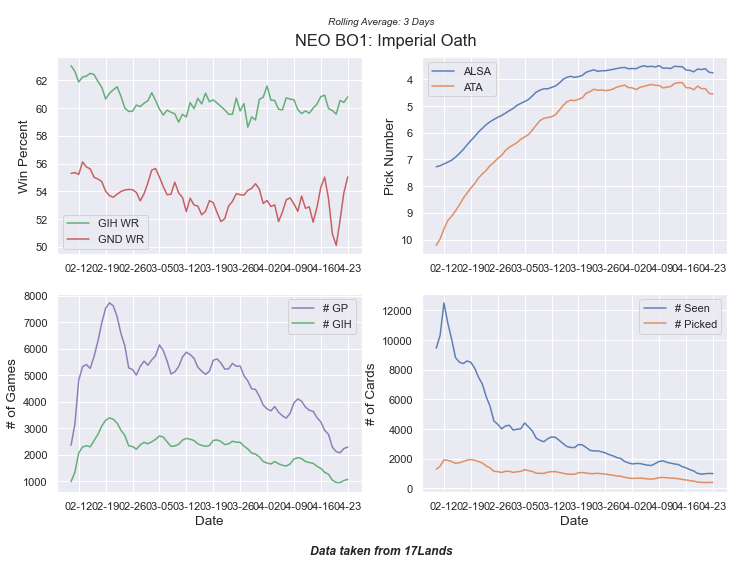

In [11]:
examiner.plot_card_summary('Imperial Oath')

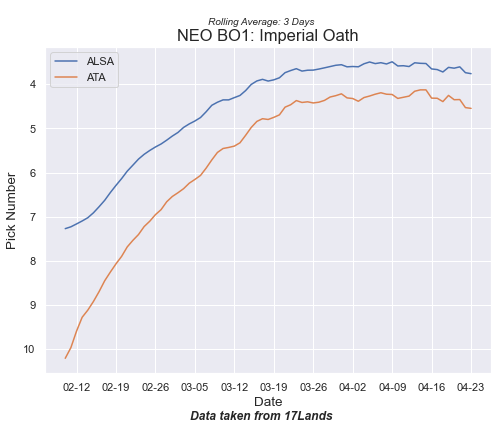

In [12]:
examiner.plot_pick_stats('Imperial Oath')

In [13]:
examiner.card_archetype_performance('Imperial Oath')

,# Seen,ALSA,# Picked,ATA,# GP,GP WR,# OH,OH WR,# GD,GD WR,# GIH,GIH WR,# GND,GND WR,IWD,Color,Rarity
AVG,274469,5.364,74907,6.261,349015,56.776,55727,56.953,101746,62.361,157473,60.447,191676,53.764,6.683,W,C
WU,274469,5.364,74907,6.261,43193,58.315,6963,58.251,14799,64.768,21762,62.683,21453,53.871,8.811,W,C
WB,274469,5.364,74907,6.261,60538,58.289,9904,58.290,17111,63.497,27015,61.588,33534,55.636,5.952,W,C
WR,274469,5.364,74907,6.261,23784,53.931,3718,54.196,5705,57.353,9423,56.107,14367,52.502,3.605,W,C
WG,274469,5.364,74907,6.261,116705,57.480,18716,57.870,32965,62.615,51681,60.897,65069,54.777,6.119,W,C
UB,274469,5.364,74907,6.261,9223,56.153,1376,56.105,2952,60.196,4328,58.896,4899,53.746,5.150,W,C
UR,274469,5.364,74907,6.261,1536,52.148,225,54.222,462,58.658,687,57.205,851,48.061,9.144,W,C
UG,274469,5.364,74907,6.261,11810,56.410,1906,55.666,3783,62.754,5689,60.380,6126,52.726,7.654,W,C
BR,274469,5.364,74907,6.261,2423,54.024,376,50.266,607,58.484,983,55.341,1440,53.125,2.216,W,C
BG,274469,5.364,74907,6.261,18260,54.830,2861,53.443,4845,60.186,7706,57.682,10563,52.750,4.932,W,C


In [14]:
examiner.stat_archetype_performance('GIH WR')

Deck Colors,,W,U,B,R,G,WU,WB,WR,WG,UB,UR,UG,BR,BG,RG,WUR,WBR,WBG,UBG,URG,WUB,WUG,WRG,UBR,BRG,WUBR,WUBG,WURG,WBRG,UBRG,WUBRG
Name,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
Acquisition Octopus,53.151,58.824,56.599,60.000,38.889,45.946,53.429,53.333,46.154,43.810,54.442,52.142,53.064,54.839,48.837,64.286,46.250,0.000,44.444,49.240,50.000,52.672,48.746,100.000,45.580,NaN,40.000,60.000,33.333,NaN,0.000,NaN
Akki Ember-Keeper,52.794,66.667,NaN,NaN,55.810,39.286,NaN,NaN,51.413,38.889,NaN,50.481,63.636,54.515,56.250,51.974,57.778,43.357,NaN,NaN,42.708,NaN,50.000,47.423,46.154,51.185,60.000,NaN,57.143,100.000,NaN,NaN
Akki Ronin,50.988,83.333,NaN,50.000,52.268,0.000,28.571,28.571,51.662,33.333,NaN,48.287,NaN,51.776,100.000,49.387,44.898,42.091,NaN,NaN,26.316,NaN,NaN,49.630,34.286,43.548,55.556,100.000,50.000,40.000,80.000,NaN
Akki War Paint,47.401,NaN,NaN,NaN,52.719,NaN,NaN,NaN,45.693,NaN,NaN,49.035,NaN,48.310,NaN,42.691,30.000,43.333,NaN,NaN,0.000,NaN,NaN,40.426,0.000,31.250,NaN,NaN,NaN,NaN,NaN,0.000
Ambitious Assault,52.054,50.000,0.000,50.000,55.669,66.667,66.667,40.000,48.325,53.333,40.000,50.756,NaN,54.247,0.000,48.762,40.000,28.302,NaN,NaN,61.905,NaN,50.000,24.324,44.828,45.000,NaN,NaN,50.000,NaN,NaN,50.000
Ancestral Katana,49.960,51.718,NaN,NaN,66.667,NaN,50.088,50.298,50.533,48.914,25.000,33.333,0.000,75.000,NaN,NaN,37.069,43.928,40.244,NaN,NaN,42.647,48.571,36.893,NaN,NaN,0.000,60.000,33.333,NaN,NaN,0.000
Anchor to Reality,48.719,33.333,52.000,NaN,50.000,66.667,48.992,75.000,33.333,50.000,46.894,50.570,45.562,0.000,NaN,NaN,26.471,NaN,NaN,37.500,0.000,53.846,70.588,NaN,50.000,NaN,NaN,NaN,NaN,NaN,NaN,NaN
"Ao, the Dawn Sky",63.713,61.905,81.818,42.857,40.000,63.158,65.762,66.204,60.020,64.746,53.061,65.116,62.366,35.000,57.085,58.824,66.197,57.143,59.843,57.778,33.333,54.286,69.444,66.038,66.667,NaN,42.857,55.172,33.333,50.000,NaN,0.000
Armguard Familiar,54.374,63.636,52.880,40.000,50.877,55.000,55.777,71.053,66.667,45.455,54.890,53.389,53.977,36.667,44.828,80.000,53.691,NaN,71.429,52.679,42.703,53.577,55.389,NaN,47.668,NaN,26.667,40.845,NaN,NaN,35.294,76.923


In [15]:
raise Exception('Stopping Auto-Run!')

Exception: Stopping Auto-Run!

## Current Tests

In [ ]:
def gt(x, y):  #Used for function pointer shenanigans
    return x > y

def lt(x, y):  #Used for function pointer shenanigans
    return x < y

def filter_quadrant_cards_df(func1, func2, iwd_thresh=0, play_lim=0.01, card_rarity=None, deck_color=''):
    frame = set_data.BO1.card_frame(deck_color=deck_color, summary=True, card_rarity=card_rarity)
    
    # TODO: Make the mean different based on card rarity so cards aren't moved into incorrect categories.
    
    if play_lim is not None:
        if type(play_lim) is float: play_lim *= set_data.BO1.get_games_played(deck_color)
        print(f'Minimum Games played to be included: {play_lim}')
        frame = frame[frame['# GP'] >= play_lim]
        
    games_played_mean = frame['# GP'].mean()
    cards = frame[func1(frame['IWD'], iwd_thresh)]
    cards = cards[func2(cards['# GP'], games_played_mean)]
    cards = cards.sort_values('IWD', ascending=func1==lt)
    return cards


def get_trap_cards(card_rarity=None, deck_color='', iwd_thresh=0, play_lim=0.01):
    return filter_quadrant_cards_df(lt, gt, iwd_thresh, play_lim, card_rarity, deck_color)

def get_niche_cards(card_rarity=None, deck_color='', iwd_thresh=0, play_lim=0.01):
    return filter_quadrant_cards_df(gt, lt, iwd_thresh, play_lim, card_rarity, deck_color)

def get_staple_cards(card_rarity=None, deck_color='', iwd_thresh=0, play_lim=0.01):
    return filter_quadrant_cards_df(gt, gt, iwd_thresh, play_lim, card_rarity, deck_color)

def get_dreg_cards(card_rarity=None, deck_color='', iwd_thresh=0, play_lim=0.01):
    return filter_quadrant_cards_df(lt, lt, iwd_thresh, play_lim, card_rarity, deck_color)

In [ ]:
get_niche_cards(deck_color='GW', card_rarity='CU')

In [ ]:
set_data.BO1.card_archetype_performance("Era of Enlightenment")

In [ ]:
fetcher = RawDataFetcher('DOM', 'PremierDraft')

In [55]:
meta_dict, card_dict = fetcher.get_day_data(date(2022, 4, 1))

In [68]:
card_dict['']

[{'seen_count': 22,
  'avg_seen': 1.0454545454545454,
  'pick_count': 22,
  'avg_pick': 1.0454545454545454,
  'game_count': 106,
  'win_rate': 0.6415094339622641,
  'sideboard_game_count': 0,
  'sideboard_win_rate': None,
  'opening_hand_game_count': 17,
  'opening_hand_win_rate': 0.6470588235294118,
  'drawn_game_count': 31,
  'drawn_win_rate': 0.7419354838709677,
  'ever_drawn_game_count': 48,
  'ever_drawn_win_rate': 0.7083333333333334,
  'never_drawn_game_count': 58,
  'never_drawn_win_rate': 0.5862068965517241,
  'drawn_improvement_win_rate': 0.12212643678160928,
  'name': 'Karn, Scion of Urza',
  'color': '',
  'rarity': 'mythic',
  'url': 'https://c1.scryfall.com/file/scryfall-cards/border_crop/front/0/7/07a3d9e8-8597-498b-869c-cff79e0df516.jpg?1562730952',
  'url_back': ''},
 {'seen_count': 1286,
  'avg_seen': 6.153965785381026,
  'pick_count': 152,
  'avg_pick': 8.822368421052632,
  'game_count': 386,
  'win_rate': 0.5880829015544041,
  'sideboard_game_count': 323,
  'sideboar

In [72]:
from WUBRG.consts import COLOR_ALIASES, COLOR_COUNT_MAP

card_data = [
            {'seen_count': 1423,
             'avg_seen': 8.179901616303583,
             'pick_count': 123,
             'avg_pick': 12.227642276422765,
             'game_count': 19,
             'win_rate': 0.21052631578947367,
             'sideboard_game_count': 511,
             'sideboard_win_rate': 0.5518590998043053,
             'opening_hand_game_count': 4,
             'opening_hand_win_rate': 0.0,
             'drawn_game_count': 5,
             'drawn_win_rate': 0.4,
             'ever_drawn_game_count': 9,
             'ever_drawn_win_rate': 0.2222222222222222,
             'never_drawn_game_count': 10,
             'never_drawn_win_rate': 0.2,
             'drawn_improvement_win_rate': 0.0222222222222222,
             'name': 'Healing Grace',
             'color': 'W',
             'rarity': 'common',
             'url': 'https://c1.scryfall.com/file/scryfall-cards/border_crop/front/f/7/f7512d31-dc35-4046-a1ba-49b74239c329.jpg?1562745837',
             'url_back': ''},
            {'seen_count': 25,
             'avg_seen': 1.92,
             'pick_count': 17,
             'avg_pick': 2.0588235294117645,
             'game_count': 52,
             'win_rate': 0.5769230769230769,
             'sideboard_game_count': 28,
             'sideboard_win_rate': 0.4642857142857143,
             'opening_hand_game_count': 6,
             'opening_hand_win_rate': 0.8333333333333334,
             'drawn_game_count': 13,
             'drawn_win_rate': 0.7692307692307693,
             'ever_drawn_game_count': 19,
             'ever_drawn_win_rate': 0.7894736842105263,
             'never_drawn_game_count': 33,
             'never_drawn_win_rate': 0.45454545454545453,
             'drawn_improvement_win_rate': 0.3349282296650718,
             'name': 'History of Benalia',
             'color': 'W',
             'rarity': 'mythic',
             'url': 'https://c1.scryfall.com/file/scryfall-cards/border_crop/front/d/1/d134385d-b01c-41c7-bb2d-30722b44dc5a.jpg?1562743350',
             'url_back': ''}
]

def gen_card_frame(card_dict: list[dict[str, object]]) -> pd.DataFrame:
    """
    Turns a dictionary into a DataFrame, with some data cleaning applied.
    :param card_dict: The dictionary containing card data for a colour group
    :return: A DataFrame filled with the cleaned card data
    """
    
    RARITY_ALIASES: dict[str, str] = {
        'common': "C",
        'uncommon': "U",
        'rare': "R",
        'mythic': "M"
    }
        
        
    STAT_NAMES: dict[str, str] = {
        "name": "Name",
        "color": "Color",
        "rarity": "Rarity",
        "seen_count": "# Seen",
        "avg_seen": "ALSA",
        "pick_count": "# Picked",
        "avg_pick": "ATA",
        "game_count": "# GP",
        "win_rate": "GP WR",
        "opening_hand_game_count": "# OH",
        "opening_hand_win_rate": "OH WR",
        "drawn_game_count": "# GD",
        "drawn_win_rate": "GD WR",
        "ever_drawn_game_count": "# GIH",
        "ever_drawn_win_rate": "GIH WR",
        "never_drawn_game_count": "# GND",
        "never_drawn_win_rate": "GND WR",
        "drawn_improvement_win_rate": "IWD"
    }
    frame = pd.DataFrame(card_dict)
    frame = frame.rename(columns=STAT_NAMES)

    # If there's no data, make a blank frame and return it.
    if card_dict is None or len(card_dict) == 0:
        return frame

    frame = frame.set_index('Name')

    for col in ["GP WR", "OH WR", "GD WR", "GIH WR", "GND WR", "IWD"]:
        frame[col] = frame[col] * 100

    frame = frame.drop(['sideboard_game_count', 'sideboard_win_rate', 'url', 'url_back'], axis=1)
    frame['Rarity'] = frame['Rarity'].map(RARITY_ALIASES)

    column_names = ['# Seen', 'ALSA', '# Picked', 'ATA', '# GP', 'GP WR', '# OH', 'OH WR', '# GD', 'GD WR', '# GIH',
                    'GIH WR', '# GND', 'GND WR', 'IWD', 'Color', 'Rarity']
    frame = frame.reindex(columns=column_names)

    frame = frame.round(3)
    return frame


frame = gen_card_frame(card_data)

In [73]:
frame

,# Seen,ALSA,# Picked,ATA,# GP,GP WR,# OH,OH WR,# GD,GD WR,# GIH,GIH WR,# GND,GND WR,IWD,Color,Rarity
Name,,,,,,,,,,,,,,,,,
Healing Grace,1423,8.180,123,12.228,19,21.053,4,0.000,5,40.000,9,22.222,10,20.000,2.222,W,C
History of Benalia,25,1.920,17,2.059,52,57.692,6,83.333,13,76.923,19,78.947,33,45.455,33.493,W,M


# TODO

- Calculate archetype openess
 - GIH WR & ALSA based
 - 2.25 of a common per draft 
- Improve graphing capabilities
 - Modify Graphs so they also save an image to a cache folder.
 - Implement better graph titles and axes
 - Update functions to be more general, and have DataFrames piped into them.
- Move sets of files into subfolders based on functionality and relationship (DataFetch, Cards, Graphing, Utils, etc.)
- Better group settings and consts into one file/location.

# Data Graphing and Display

## Card Summary

In [ ]:
set_data.BO1.plot_card_summary('Imperial Oath')

In [ ]:
set_data.BO1.plot_card_summary("Befriending the Moths", roll=3)

In [ ]:
set_data.BO1.plot_card_summary("Michiko's Reign of Truth", roll=3)

In [ ]:
set_data.BO1.plot_card_summary("The Fall of Lord Konda", roll=3)

In [ ]:
set_data.BO1.plot_card_summary('Sunblade Samurai', roll=3)

In [ ]:
set_data.BO1.get_top('GIH WR', count=25, asc=False, deck_color='', card_color=None, card_rarity='RM', play_lim=0.005)

## Card Pick Order Stats

In [ ]:
set_data.BO1.plot_pick_stats('Imperial Oath')

In [ ]:
set_data.BO1.plot_pick_stats('Behold the Unspeakable', 3)

In [ ]:
to_graph = ['Imperial Oath', 'Behold the Unspeakable', 'Virus Beetle', 'Network Disruptor', 'Kumano Faces Kakkazan', 'Iron Apprentice']
for card in to_graph:
    set_data.BO1.plot_pick_stats(card, 3)

## Archetype Winrate History

In [ ]:
set_data.BO1.get_archetype_winrate_history()

In [ ]:
set_data.BO1.plot_archetype_winrate_history('')

In [ ]:
set_data.BO3.plot_archetype_winrate_history('')

## Archetype Playrate History

In [ ]:
set_data.BO1.get_archetype_playrate_history()

In [ ]:
set_data.BO1.plot_archetype_playrate_history('')

In [ ]:
set_data.BO3.plot_archetype_playrate_history('')

## Card Pick Order Changes

In [ ]:
diff = set_data.BO1.compare_card_evaluations('2022-02-10', '2022-03-27')
commons = diff[diff['Rarity'] == 'C']
uncommons = diff[diff['Rarity'] == 'U']

In [ ]:
SRT_TRG = 'Δ ATA'
commons.sort_values(SRT_TRG, ascending=False).head(20)

In [ ]:
commons.sort_values(SRT_TRG, ascending=True).head(20)

In [ ]:
uncommons.sort_values(SRT_TRG, ascending=False).head(10)

In [ ]:
uncommons.sort_values(SRT_TRG, ascending=True).head(10)